In [39]:
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torchvision.utils import save_image

In [40]:
# Load vgg19 pretrained model
vgg = models.vgg19(pretrained=True)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [41]:
# set device to cuda or cpu, based on availability 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 256 

# transform for image
mean = torch.tensor([0.4915, 0.4823, 0.4468])
std = torch.tensor([0.2470, 0.2435, 0.2616])
loader = transforms.Compose(
    [
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor(),
        # transforms.Normalize(mean.tolist(), std.tolist())
    ]
)

unloader = transforms.Compose(
    [
        # transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist()),
        transforms.ToPILImage()  # reconvert into PIL image
    ]
)

In [42]:
# NST VGG model
class VGG_NST(nn.Module):
  def __init__(self, features):
    super(VGG_NST, self).__init__()
    # use conv1_1, conv2_1, conv3_1, conv4_1, conv5_1 as mentioned in NST paper
    # ["0", "5", "10", "19", "28"] layer from vgg19
    self.chosen_features = features

    # we don't need to run anything further than conv5_1 layer
    self.model = models.vgg19(pretrained=True).features[:29]

  def forward(self, x):
    # stores relevant features from output
    features = []

    # Go through each layer in model and store the output of the layer 
    # in features, if the layer is in the chosen_features. 
    # Return all the activations for the specific layers in chosen_features.
    for layer_num, layer in enumerate(self.model):
      x = layer(x)
      if str(layer_num) in self.chosen_features:
        features.append(x)

    return features

In [43]:
# gets content loss between content image and target image
def get_content_loss(content, target):
  # gets mean square error between content and target vector
  loss = F.mse_loss(content, target)
  return loss

# creates gram matrix for tensor
def gram_matrix(input):
  b, c, h, w = input.size()  
  # shape: (batch, channel, height, width)
  features = input.view(b*c, h*w) 
  # computes gram matrix product 
  G = torch.mm(features, features.t()) 
  # normalize the values 
  return G.div(b*c*h*w)

# gets style loss between style image and target image
def get_style_loss(style, target):
  # gets gram matrix for both style and target tensors
  S = gram_matrix(style)
  T = gram_matrix(target)

  # gets mean square error between style and target vector
  loss = F.mse_loss(S, T)
  return loss

In [44]:
# loads image as tensor
def image_loader(image_name):
  image = Image.open(image_name)
  # insert batch dimension 
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

# displays tensor as image
def imshow(tensor, title=None):
  # clone tensor and move to cpu
  image = tensor.cpu().clone()  
  # removes batch dimension
  image = image.squeeze(0)      
  image = unloader(image)

  fig = plt.figure(figsize=(5,5))
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.xticks([])
  plt.yticks([])
  plt.show()


In [45]:
# Executes style transfer for num_steps number of iterations to apply 
# style on content image 
def run_style_transfer(model, content_img, style_img, generated_img, 
                       num_steps=500, content_weight=1, style_weight=0.1, 
                       learning_rate=0.001, content_layer=2, style_layer_count=5,
                       init_image=0):
  # sets model to eval mode
  model.eval()
  # sets requires_grad to True for generated_img as the activation on the image
  # needs to be corrected with each iteration
  generated_img.requires_grad_(True)
  model.requires_grad_(False)
  optimizer = optim.Adam([generated_img], lr=learning_rate)

  # for logging purpose (between content/noise image as starting image)
  if init_image == 0:
    start_image = 'Content'
  else:
    start_image = 'Noise'

  print('=' * 50)
  print(f'Processing Image combination ==> Content layer: {content_layer}, Style layer before: {style_layer_count}, Initial Image: {start_image}')
  print('=' * 50)

  # gets features for content and style image, to be used in loss calculation
  content_features = model(content_img)
  style_features = model(style_img)
    
  for step in range(num_steps):
    # correct the values of updated input image
    with torch.no_grad():
      generated_img.clamp_(0, 1)

    # gets the convolution features for generated image
    generated_features = model(generated_img)

    style_loss = content_loss = 0
    #calculates content loss for the specified conv layer
    content_loss += get_content_loss(content_features[content_layer], generated_features[content_layer])

    count = 0
    # iterate through all the features for the chosen layers 
    for generated_feature, style_feature in zip(
      generated_features, style_features
      ):
      # calculates style loss for given layers
      if count < style_layer_count:
        style_loss += get_style_loss(style_feature, generated_feature)
        count += 1

    # gets total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if (step+1) % 1000 == 0:
      print(f'Step: {step+1}/{num_steps} ==> Loss: {total_loss}')
    
  print(f'Final Image generated!!!')
  # returns final generated image
  return generated_img

## Trying different combinations for content and style layers

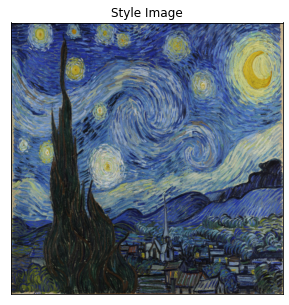

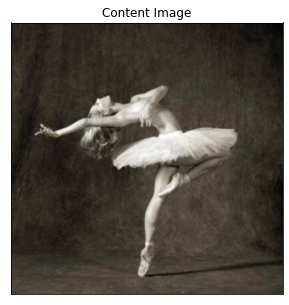

In [46]:
# for testing
# sets style and content image
style_img = image_loader("style1.jpeg")
content_img = image_loader("dancing.jpeg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')

In [47]:
# sets vgg19 layers for conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
feature_layers = ["0", "5", "10", "19", "28"]
model = VGG_NST(feature_layers).to(device)
# hyperparameters
num_steps = 5000
learning_rate = 0.01
alpha = 1
beta = 1000000

# runs test for different content and style settings
for content in range(5):
  for style in range(1, 6):
    for init in range(2):
      # sets contentimage or noise as starting target image
      if init == 0:
        generated_img = content_img.clone().to(device)
      else:
        generated_img = torch.randn(content_img.data.size(), device=device)
      
      # runs style loop
      output_img = run_style_transfer(model, content_img, style_img, generated_img, 
                                         num_steps, alpha, beta, learning_rate,
                                         content, style, init)
      
      imshow(output_img, title='Generated Image')
      img_name = "out_" + str(content) + "_" + str(style) + "_" + str(init) + ".png"
      save_image(output_img, img_name)
      print(f'Image {img_name} Saved!!\n')

Output hidden; open in https://colab.research.google.com to view.

#### 4_4_0 seems good (5th content, 0-3 style)
#### 2_4_0 also looks good (3rd content, 0-3 style)

## Testing

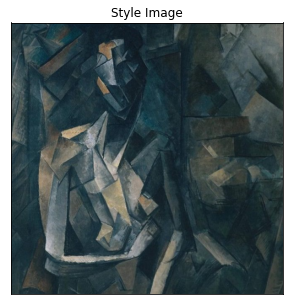

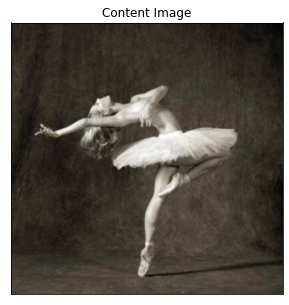

Processing Image combination ==> Content layer: 2, Style layer before: 4, Initial Image: Content
Step: 1000/5000 ==> Loss: 0.19090081751346588
Step: 2000/5000 ==> Loss: 0.18892863392829895
Step: 3000/5000 ==> Loss: 0.19447572529315948
Step: 4000/5000 ==> Loss: 0.2659338116645813
Step: 5000/5000 ==> Loss: 0.1824105829000473
Final Image generated!!!


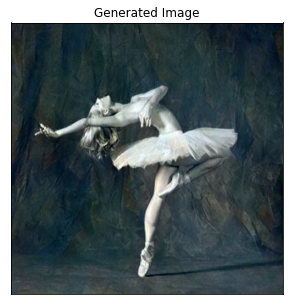

Processing Image combination ==> Content layer: 4, Style layer before: 4, Initial Image: Content
Step: 1000/5000 ==> Loss: 0.04452838376164436
Step: 2000/5000 ==> Loss: 0.06051646173000336
Step: 3000/5000 ==> Loss: 0.04352864623069763
Step: 4000/5000 ==> Loss: 0.049439311027526855
Step: 5000/5000 ==> Loss: 0.04704113304615021
Final Image generated!!!


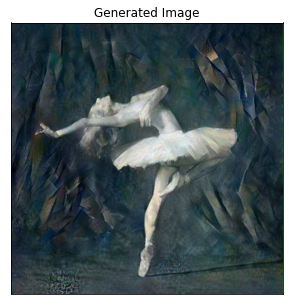

In [52]:
# test for different style
style_img = image_loader("style.jpeg")
content_img = image_loader("dancing.jpeg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')

feature_layers = ["0", "5", "10", "19", "28"]
model = VGG_NST(feature_layers).to(device)
# Hyperparameters
num_steps = 5000
learning_rate = 0.01
alpha = 1
beta = 1000000

# conv3_1 as content layer and aa 5 conv layers as style layer 
generated_img = content_img.clone().to(device)
output_img = run_style_transfer(model, content_img, style_img, generated_img, 
                                num_steps, alpha, beta, learning_rate,
                                2, 4, 0)
imshow(output_img, title='Generated Image')

# conv5_1 as content layer and aa 5 conv layers as style layer
generated_img = content_img.clone().to(device)
output_img = run_style_transfer(model, content_img, style_img, generated_img, 
                                num_steps, alpha, beta, learning_rate,
                                4, 4, 0)
imshow(output_img, title='Generated Image')

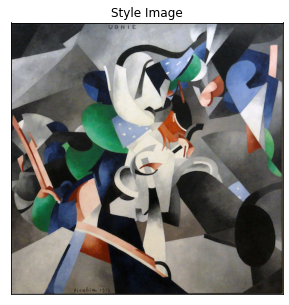

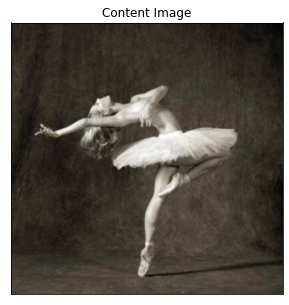

Processing Image combination ==> Content layer: 2, Style layer before: 4, Initial Image: Content
Step: 1000/5000 ==> Loss: 1.1280978918075562
Step: 2000/5000 ==> Loss: 1.107175350189209
Step: 3000/5000 ==> Loss: 1.1025973558425903
Step: 4000/5000 ==> Loss: 1.0955650806427002
Step: 5000/5000 ==> Loss: 1.0990500450134277
Final Image generated!!!


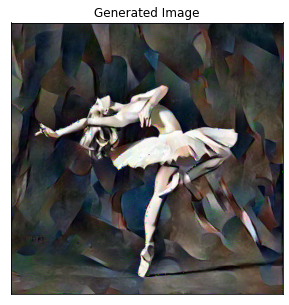

Processing Image combination ==> Content layer: 4, Style layer before: 4, Initial Image: Content
Step: 1000/5000 ==> Loss: 0.34885889291763306
Step: 2000/5000 ==> Loss: 0.3443375825881958
Step: 3000/5000 ==> Loss: 0.2814423441886902
Step: 4000/5000 ==> Loss: 0.2729949355125427
Step: 5000/5000 ==> Loss: 0.26215457916259766
Final Image generated!!!


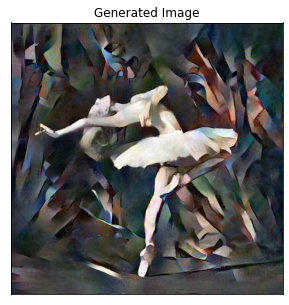

In [53]:
# test for different style
style_img = image_loader("style6.jpeg")
content_img = image_loader("dancing.jpeg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')

feature_layers = ["0", "5", "10", "19", "28"]
model = VGG_NST(feature_layers).to(device)
# Hyperparameters
num_steps = 5000
learning_rate = 0.01
alpha = 1
beta = 1000000

# conv3_1 as content layer and aa 5 conv layers as style layer 
generated_img = content_img.clone().to(device)
output_img = run_style_transfer(model, content_img, style_img, generated_img, 
                                num_steps, alpha, beta, learning_rate,
                                2, 4, 0)
imshow(output_img, title='Generated Image')

# conv5_1 as content layer and aa 5 conv layers as style layer
generated_img = content_img.clone().to(device)
output_img = run_style_transfer(model, content_img, style_img, generated_img, 
                                num_steps, alpha, beta, learning_rate,
                                4, 4, 0)
imshow(output_img, title='Generated Image')